In [1]:
## Prashant Neel
#use reanalysis data to plot time series of maximum daily June/July temperatures for each year
#plot geopotential and wind streamlines for heatwave day
#Siberia region, 2020 heatwave

###INPUTS

# In[]: Specify the path out for all figures that will be saved i.e. the path to your directory on linux or the directory you wish to 
# save the figures
pathout ="/nfs/see-fs-01_teaching/ee21pnm"

# In[]: Specify the year, month, hours and days for which you wish to plot data for
#25 june to 7 July
year = "2020"
mon= "06"
month= 'June'
day = 20

#
#Specify the longitude value you wish to plot a cross-section through
lat_cross_section = 65


# if you want to output files for all times and all days then take the # away from the below two lines. 
#hours = ["00", "12"] 
#days = ['08', '09']

#Lat long boundaries
#Specify min and max values of latitude and longitude 
lat_min = 50
lat_max =90
lon_min = 60
lon_max = 180

#step between each gridline
step = 5
#gridlines
xlist = [*range(lon_min,lon_max+step,step)]
ylist = [*range(lat_min,lat_max+step,step)]

#pressure levels, maybe loop
pressure_level = 500


#Cities to Plot
def plot_cities(ax):
    lats = [45.523064, 47.6062, 49.2827]
    lons = [-122.676483, -122.3321, -123.1207]
    cities = ['Portland', 'Seattle', 'Vancouver']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'wo', zorder=5, MarkerSize=1, transform=ccrs.PlateCarree())
        ax.text(lon + 0.1, lat, city, fontsize='medium',color='white',fontweight='bold',
                transform=ccrs.PlateCarree())
                
def plot_siberian_cities(ax):
    lats = [67.550]
    lons = [133.383]
    cities = ['Verkhoyansk']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'w.', zorder=1, MarkerSize=4, transform=ccrs.PlateCarree())
        ax.text(lon + 0.2, lat , city, fontsize='small',fontweight='bold',color='white',transform=ccrs.PlateCarree())
        
def plot_siberian_cities_large(ax):
    lats = [67.550]
    lons = [133.383]
    cities = ['Verkhoyansk']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'w.', zorder=1, MarkerSize=4, transform=ccrs.PlateCarree())
        ax.text(lon + 0.2, lat , city, fontsize='medium',fontweight='bold',color='white',transform=ccrs.PlateCarree())

In [2]:
##IMPORT PACKAGES

import cartopy.feature as cfeature ## for lakes/borders et
countries_50m = cfeature.NaturalEarthFeature('cultural','admin_0_countries','50m',edgecolor='k',facecolor='none')
import cartopy.crs as ccrs
import numpy as np
from netCDF4 import Dataset  
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing
import datetime as dt
from matplotlib import gridspec
from matplotlib import rcParams

import iris
from iris.experimental.equalise_cubes import equalise_attributes
from iris.util import unify_time_units
import iris.coord_categorisation
import iris.plot as iplt
import iris.quickplot as qplt
import pandas as pd
import matplotlib.colors as clrs

import glob

crs = ccrs.PlateCarree()

##define constants
p0 = 1000   #base pressure level
rcp = 0.286 #gas constant divided by specific heat capacity
R_gas= 8.31 #ideal gas constant
G = 9.81 #gravity

#make function to convert all floats to integers in a matrix
def f1(x):
    return np.int(x)
f2 = np.vectorize(f1)

tas_constraint = iris.Constraint(cube_func=lambda cube: cube.var_name == 'tas')

#functions 

#make boundary for ALbers Equal Area Projection

import matplotlib.path as mpath

def make_boundary_path_sector_map(lons,lats):
    """
    Created on Thurs Feb 11 14:34 2021

    @author: Christine McKenna

    ===========================================================
    Purpose: Function to make a path around boundary to create
             a sector map
    ===========================================================
    """
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],\
                              lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],\
                              lats[0,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,0],\
                              lats[:,0]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

# Change to be the boundary you want
lats_bound = np.linspace(50,90,41) 
lons_bound = np.linspace(60,179,120)
[llo_bnd,lla_bnd] = np.meshgrid(lons_bound,lats_bound)
boundary_path = make_boundary_path_sector_map(llo_bnd,lla_bnd)



#make function for legend for streamplot

def speedToLW(wspeed, maxspeed):
    ''' 
    Function to convert windspeed into a sensible linewidth
    This will need to change depending on your data
    '''
    return 2*wspeed / maxspeed

def LWToSpeed(lw,maxspeed):
    ''' The inverse of speedToLW, to get the speed back from the linewidth '''
    return (lw/2) * maxspeed 

def makeStreamLegend(strm, lx, convertFunc,maxspeed, nlines=5, color='k', fmt='{:g}'):

    ''' Make a legend for a streamplot on a separate axes instance '''

    # Get the linewidths from the streamplot LineCollection
    lws = np.array(strm.lines.get_linewidths())

    # Turn off axes lines and ticks, and set axis limits
    lx.axis('off')
    lx.set_xlim(0, 1)
    lx.set_ylim(0, 1)

    # Loop over the desired number of lines in the legend
    for i, y in enumerate(np.linspace(0.1, 0.9, nlines)):

        # This linewidth
        lw = lws.min()+float(i) * lws.ptp()/float(nlines-1)

        # Plot a line in the legend, of the correct length
        lx.axhline(y, 0.1, 0.4, c=color, lw=lw)

        # Add a text label, after converting the lw back to a speed
        lx.text(0.5, y, fmt.format(convertFunc(lw,maxspeed)), va='center')

/apps/developers/compilers/canopy3/2.1.3/1/bit-64/Canopy/edm/envs/User/lib/python3.5/site-packages/matplotlib/ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


In [3]:
##Read in geopotential data

nc = Dataset("/nfs/annie/ee21pnm/ERA5_vertical_4/"+str(year)+"_"+str(mon)+"_z.nc","r")

#information on the file's variables
#print(nc.variables.keys())
#for var in ['time', 'plev', 'lat', 'lon', 'z']:
#    print(var,nc.variables[var])
    
    
lat = nc.variables['lat'][:]  
lon = nc.variables['lon'][:]
z = nc.variables['z'][:]
time = nc.variables['time'][:]
p_pa = nc.variables['plev'][:]

#convert from pascals to Hpa
p1 = p_pa/100
p2 = p1.astype(int)

#reorder ascending pressure levels
p_indcs = np.argsort(p2)
p = p2[p_indcs]

#adjust z for new pressure order
z = z[:,p_indcs,:,:]

widths = np.linspace(0, 1, lat.size)

# Convert all the times in the file to datetime objects
dt_time = [dt.date(1900, 1, 1) + dt.timedelta(hours=int(t)) for t in time]

#convert to array
dt_time2 = np.array(dt_time)

##Read in u data

ncU = Dataset("/nfs/annie/ee21pnm/ERA5_vertical_4/"+str(year)+"_"+str(mon)+"_u.nc","r")


#information on the file's variables
#print(ncW.variables.keys())
#for var in ['w']:
    #print(var,ncW.variables[var])
    
u = ncU.variables['u'][:]
timeU = ncU.variables['time'][:]

#adjust u for new pressure order
u = u[:,p_indcs,:,:]


# Convert all the times in the file to datetime objects
dt_timeU = [dt.date(1900, 1, 1) + dt.timedelta(hours=int(t)) for t in timeU]
#convert to array
dt_timeU2 = np.array(dt_timeU)


#repeat for V

ncV = Dataset("/nfs/annie/ee21pnm/ERA5_vertical_4/"+str(year)+"_"+str(mon)+"_v.nc","r")


#information on the file's variables
#print(ncV.variables.keys())
#for var in ['w']:
    #print(var,ncW.variables[var])

v = ncV.variables['v'][:]
timeV = ncV.variables['time'][:]

#adjust v for new pressure order
v = v[:,p_indcs,:,:]



# Convert all the times in the file to datetime objects
dt_timeV = [dt.date(1900, 1, 1) + dt.timedelta(hours=int(t)) for t in timeV]
#convert to array
dt_timeV2 = np.array(dt_timeV)


/apps/developers/compilers/canopy3/2.1.3/1/bit-64/Canopy/edm/envs/User/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


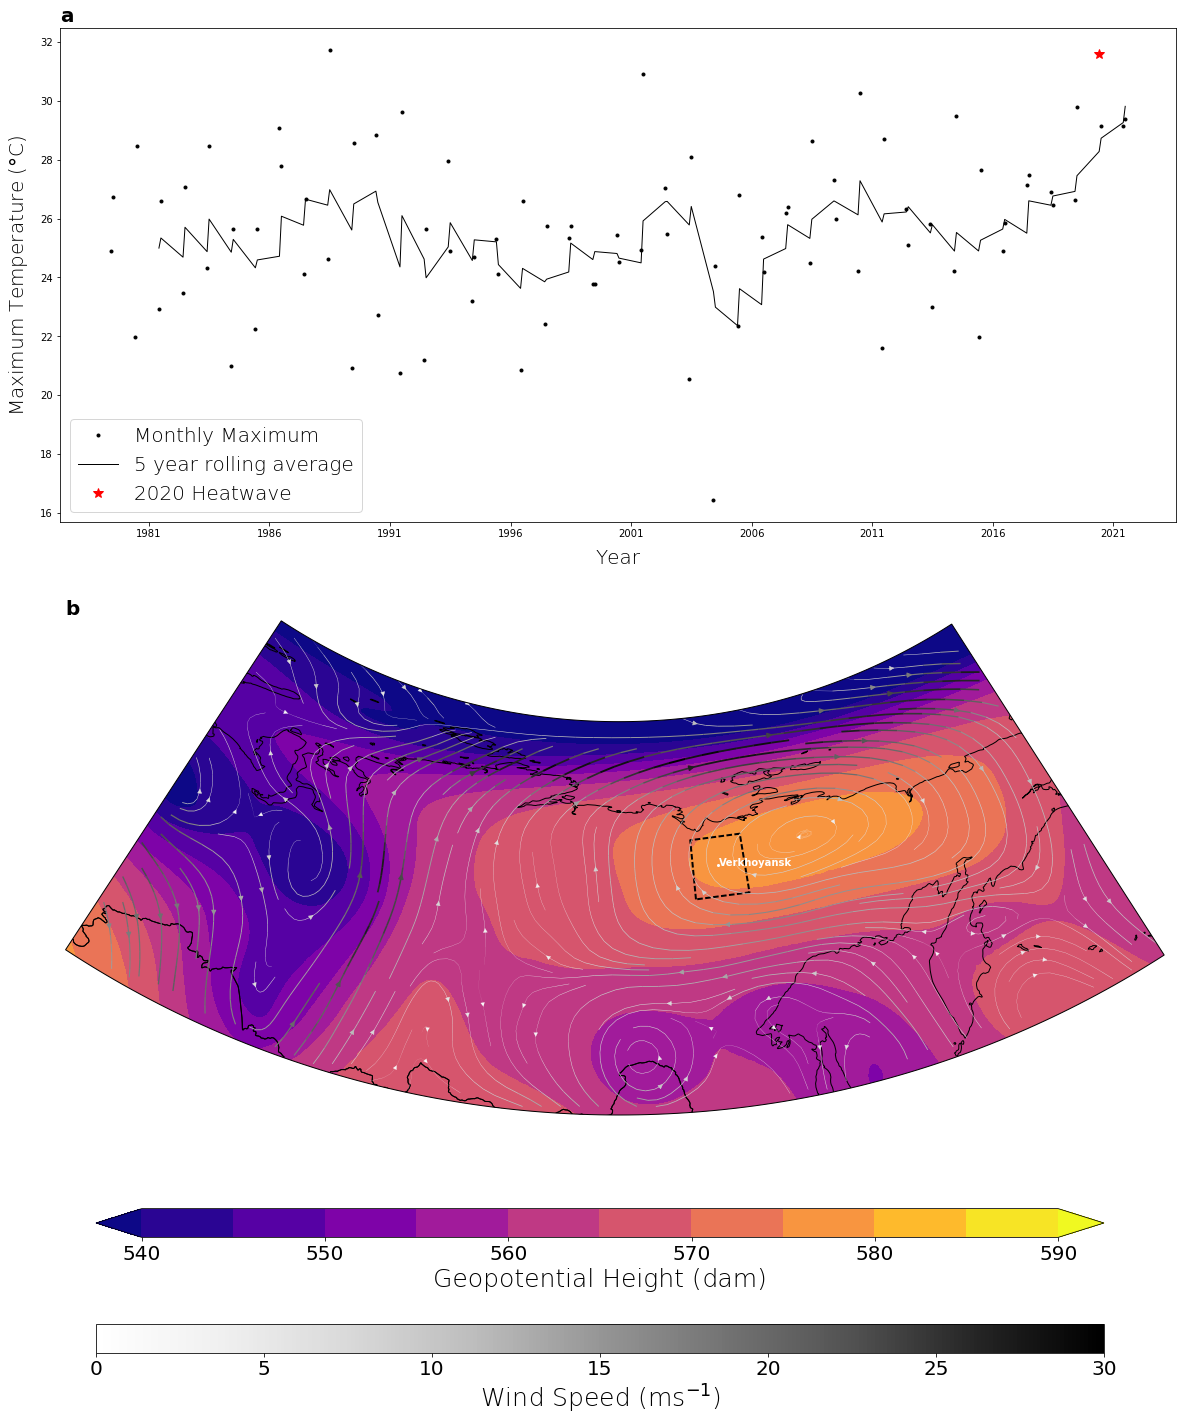

In [8]:
plt.rcParams.update({'figure.max_open_warning': 0})
    
#slice the data

p_lev = pressure_level # this indicates hPa level
p_level = str(p_lev) # this is used to label the figures which are saved at the end
pressure = np.where(p==p_lev)

#find index for temp

date_index_array = np.where(dt_time2==dt.date(int(year),int(mon),day)) #2589
date_index = np.squeeze(date_index_array)

#repeat for u,v,w
date_index_arrayU = np.where(dt_timeU2==dt.date(int(year),int(mon),day))
date_indexU = np.squeeze(date_index_arrayU)
date_index_arrayV = np.where(dt_timeV2==dt.date(int(year),int(mon),day))
date_indexV = np.squeeze(date_index_arrayV)

z_slice = np.squeeze(z[date_index,pressure,:,:])
u_slice = np.squeeze(u[date_indexU,pressure,:,:])
v_slice = np.squeeze(v[date_indexV,pressure,:,:])

#convert to geopotential height
z_height = (z_slice/G)/10

# Find where in the longitude array the values are between lon_min and lon_max 
lons = np.where((lon >= lon_min) & (lon <= lon_max))[0]

# Gives an array which is the subdomain of the longitude values 
lon_subset = lon[lons]

#Find the values in the longitude array at which this subsection range of longitudes lies between
lon_min_index = np.min(lons)  
lon_max_index = np.max(lons) + 1
#print lon_subset, 'lon_subset'
#Repeat for latitude
lats = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lat_subset = lat[lats]
lat_min_index =np.min(lats) 
lat_max_index = np.max(lats) +1
#print lat_subset ,'lat_subset'

# Initiate new Figure
fig1 = plt.figure(figsize=(20,20))
fig1.patch.set_facecolor('w')
#gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 


#ax1 = fig1.add_subplot(gs[0],projection=ccrs.AlbersEqualArea(90,65))
ax1 = fig1.add_subplot(2,1,2,projection=ccrs.AlbersEqualArea(120,65))

#legend
#lx = fig1.add_subplot(gs[1])

#albers equal area
#ax1 = fig1.add_subplot(1,1,1,projection=ccrs.AlbersEqualArea(np.mean((lon_min,lon_max))))
#ax1.set_boundary(boundary_path,transform=ccrs.PlateCarree())
#ax1.set_extent((lon_min,lon_max,lat_min,lat_max-step))
#ax1.set_extent((lon_min+30,lon_max-30,lat_min+10,lat_max-10))
ax1.set_boundary(boundary_path,transform=ccrs.PlateCarree())

clevels = [540,545,550,555,560,565,570,575,580,585,590]


im1 = ax1.contourf(lon_subset, lat_subset, z_height[lat_min_index:lat_max_index, lon_min_index:lon_max_index],
levels=clevels, transform=ccrs.PlateCarree(),cmap='plasma',extend='both')


#add gridlines
ax1.add_feature(countries_50m, linewidth=1)
#gl = ax1.gridlines(color="black", linestyle="dotted",draw_labels='True') #,draw_labels='True')
#gl.xlabels_top = False
#gl.ylabels_left = False
#gl.xlines = True
#gl.ylines = True
#gl.xlocator = mticker.FixedLocator((xlist))
#gl.ylocator = mticker.FixedLocator((ylist))
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER

#add latitude cross section line
#im3 = ax1.plot(np.linspace(60, 160, 200),[65] * 200,linewidth=2, transform=ccrs.Geodetic(), color='k',linestyle='dashed')

#generate wind speed magnitudes from u and v
wspeed_all = np.sqrt((u_slice**2)+(v_slice**2))
wspeed = wspeed_all[lat_min_index:lat_max_index, lon_min_index:lon_max_index]
#lw = 2*wspeed / wspeed.max()
lw = speedToLW(wspeed, wspeed.max())


    #plot stream plot
strm = ax1.streamplot(lon_subset, lat_subset, u_slice[lat_min_index:lat_max_index, lon_min_index:lon_max_index], 
v_slice[lat_min_index:lat_max_index, lon_min_index:lon_max_index], transform=crs, linewidth=lw, color=wspeed, cmap='Greys',
density = 2, norm = clrs.Normalize(vmin=0,vmax=30),
arrowsize=1, arrowstyle='-|>', minlength=0.1,zorder=None, start_points=None )


#add box/square
sq_lons = [130, 130, 137, 137]
sq_lats = [65, 70, 70, 65]
#Specify min and max values of latitude and longitude 
ring = LinearRing(list(zip(sq_lons, sq_lats)))
ax1.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=2,linestyle='dashed')

#pattern corr box
#sq_lons2 = [50, 50, 210, 210]
#sq_lats2 = [40, 90, 90, 40]
#Specify min and max values of latitude and longitude 
#ring2 = LinearRing(list(zip(sq_lons2, sq_lats2)))
#ax1.add_geometries([ring2], ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=2,linestyle='dashed')

#plot major cities
plot_siberian_cities_large(ax1)

#colorbar
#axes are left, bottom, width, height
cax = fig1.add_axes([0.15, 0.04, 0.7, 0.02])
cbar = fig1.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('Geopotential Height (dam)', size = 25, fontweight='light') #, fontweight = 'light'
cbar.ax.tick_params(labelsize=20) 

cax2 = fig1.add_axes([0.15, -0.04, 0.7, 0.02])
stream_cbar = fig1.colorbar(strm.lines, ax=ax1, cax=cax2, orientation='horizontal')
stream_cbar.set_label('Wind Speed (ms$^{-1}$)', size = 25, fontweight='light')
stream_cbar.ax.tick_params(labelsize=20) 
#cbar.outline.set_linewidth(0.5)
#cbar.ax.tick_params(labelsize=10)
#cbar.set_label('Geopotential Height (dam)',fontsize=10)
#fig1.subplots(sharex=True, sharey=True)
#fig1.subplots_adjust(wspace=0.1, hspace=0.1)
#fig1.tight_layout()
#fig1.savefig(pathout+'/ERA_interim_Geopotential_Height.png',format ='png', dpi=150, bbox_inches='tight')

#make linewidth legend
#makeStreamLegend(strm, lx, LWToSpeed,wspeed.max(), nlines=3, fmt='{:6.3f}')



#Save and show the figure
#ax1.set_title(str(day)+'.'+str(mon)+'.'+str(year)+'_'+str(p_level)+'hPa Geopotential Height and Wind Vectors',fontsize=15)
#plt.savefig('hh.png',format ='png', dpi=300, bbox_inches='tight')


#time series

#load Siberia dataframe
df = pd.read_excel('Spreadsheets/Siberia_MaxT2m.xlsx', index_col=0)
#find heatwave day
df_HW = df.loc[df['dates'] == '2020-06-01']
df_June = df.loc[df['dates'].dt.month == 6]
df_July = df.loc[df['dates'].dt.month == 7]

#matplotlib
ax2 = fig1.add_subplot(2,1,1)
ax2.plot(df.dates,df.Max_Temp, 'ko-', linewidth=0, markersize =3,label='Monthly Maximum')
#ax1.plot(df.dates,df.maxTemp_5year_ave, 'b-', linewidth=1, markersize =3, label='5 year rolling average')
ax2.plot(df.dates,df.maxTemp_5year_ave, '-', color='black', linewidth=1, markersize =3,label='5 year rolling average')
#plot HW
ax2.plot(df_HW.dates,df_HW.Max_Temp, 'r*', linewidth=0, markersize =10,label='2020 Heatwave')
plt.legend(prop={'size': 20, 'weight':'light'})
ax2.set_title('a', size=20, fontweight='bold',loc='left')
ax1.set_title('b', size=20, fontweight='bold',loc='left')


plt.ylabel('Maximum Temperature ($\degree$C)', fontsize=20, labelpad = 10, fontweight='light')
plt.xlabel('Year', fontsize=20,labelpad = 10, fontweight='light')


plt.savefig('Siberia_heatwave.png',format ='png', dpi=300, bbox_inches='tight')



plt.show()

In [6]:
df['year'] = df['dates'].dt.year
df
#df_YearMax['year', 'Max_Temp'] = df.groupby(['year'], sort=False)['Max_Temp'].max()
df_YearMax = df.loc[df.groupby(["year"])["Max_Temp"].idxmax()] 
df_YearMax

,dates,Max_Temp,maxTemp_3year_ave,maxTemp_5year_ave,maxTemp_10year_ave,year
1,1979-07-01,26.737017,NaN,NaN,NaN,1979
3,1980-07-01,28.456297,25.724489,NaN,NaN,1980
5,1981-07-01,26.605539,25.993888,25.339767,NaN,1981
7,1982-07-01,27.061743,25.715177,25.704331,NaN,1982
9,1983-07-01,28.456409,26.609948,25.982726,25.489392,1983
11,1984-07-01,25.658783,25.029566,25.292426,24.990220,1984
13,1985-07-01,25.647839,24.512559,24.593518,24.734464,1985
14,1986-06-01,29.085245,25.654713,24.719285,25.351006,1986
17,1987-07-01,26.654139,26.186443,26.658483,25.492386,1987
19,1988-07-01,31.720688,27.669034,26.982458,25.850872,1988


/apps/developers/compilers/canopy3/2.1.3/1/bit-64/Canopy/edm/envs/User/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


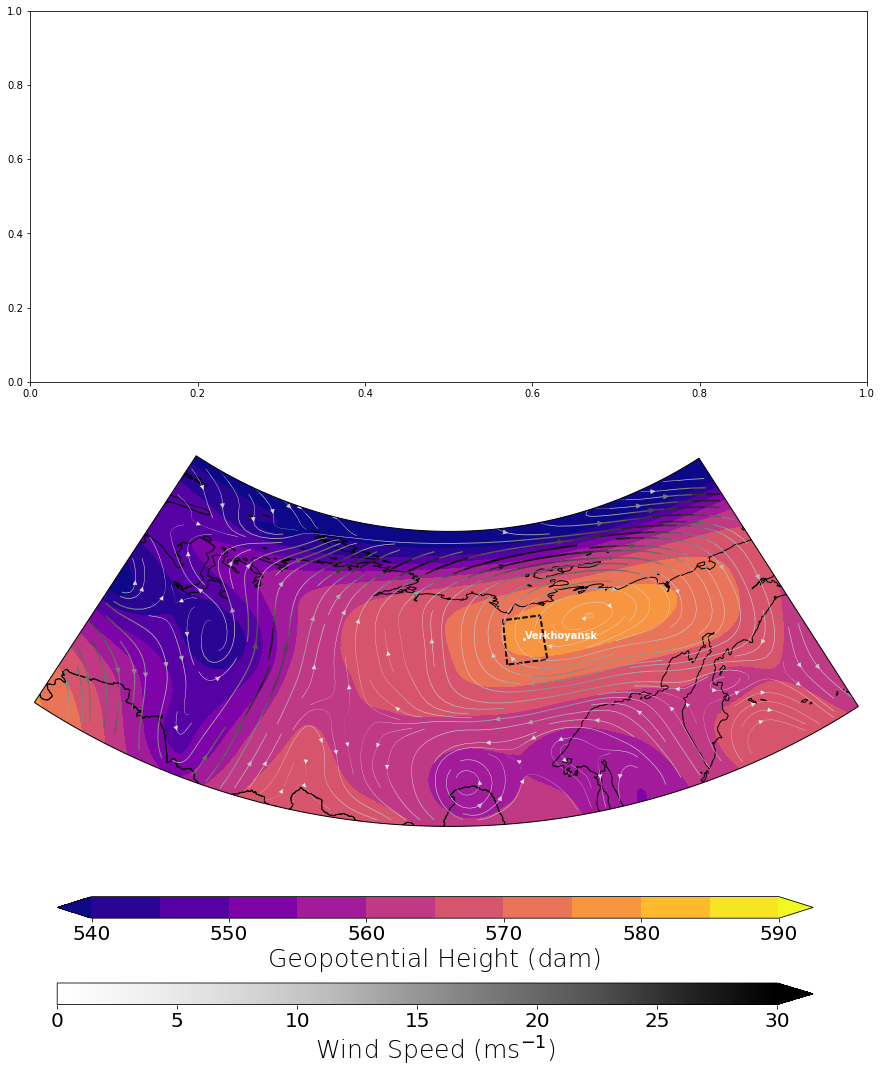

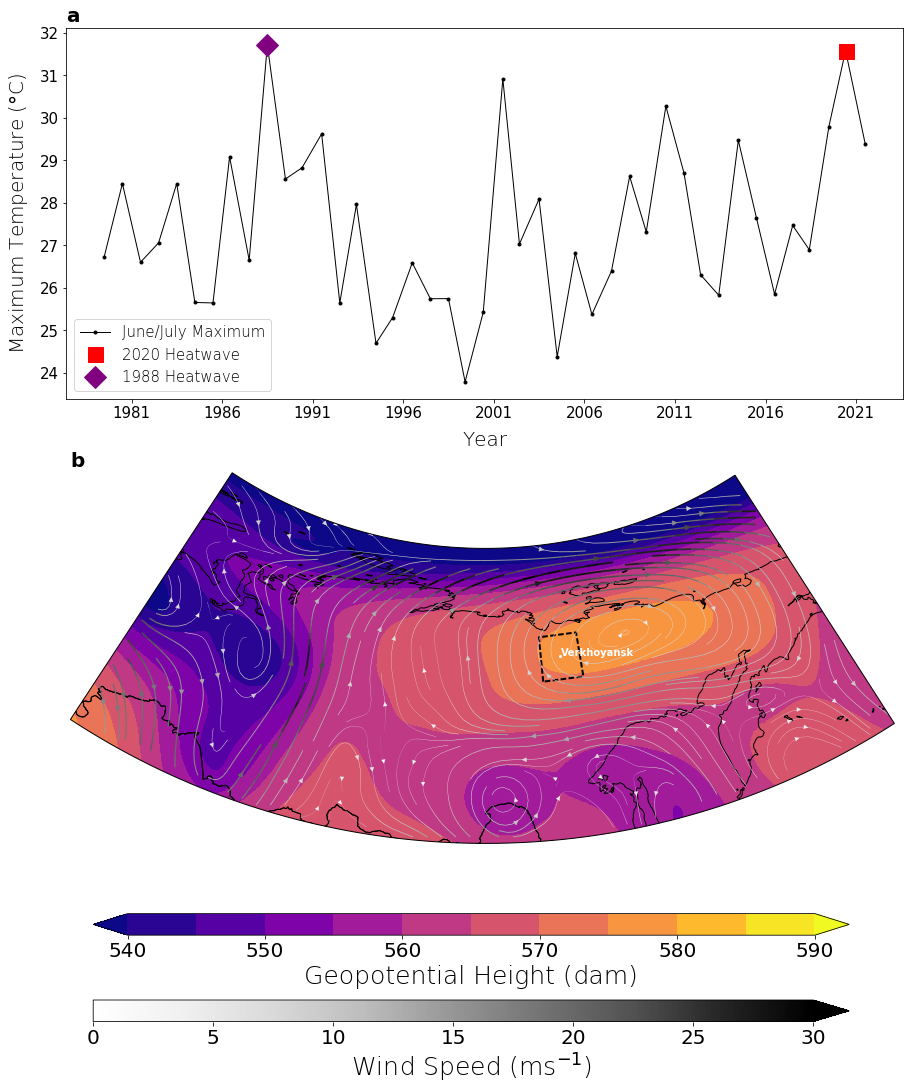

In [7]:
plt.rcParams.update({'figure.max_open_warning': 0})
    
#slice the data

p_lev = pressure_level # this indicates hPa level
p_level = str(p_lev) # this is used to label the figures which are saved at the end
pressure = np.where(p==p_lev)

#find index for temp

date_index_array = np.where(dt_time2==dt.date(int(year),int(mon),day)) #2589
date_index = np.squeeze(date_index_array)

#repeat for u,v,w
date_index_arrayU = np.where(dt_timeU2==dt.date(int(year),int(mon),day))
date_indexU = np.squeeze(date_index_arrayU)
date_index_arrayV = np.where(dt_timeV2==dt.date(int(year),int(mon),day))
date_indexV = np.squeeze(date_index_arrayV)

z_slice = np.squeeze(z[date_index,pressure,:,:])
u_slice = np.squeeze(u[date_indexU,pressure,:,:])
v_slice = np.squeeze(v[date_indexV,pressure,:,:])

#convert to geopotential height
z_height = (z_slice/G)/10

# Find where in the longitude array the values are between lon_min and lon_max 
lons = np.where((lon >= lon_min) & (lon <= lon_max))[0]

# Gives an array which is the subdomain of the longitude values 
lon_subset = lon[lons]

#Find the values in the longitude array at which this subsection range of longitudes lies between
lon_min_index = np.min(lons)  
lon_max_index = np.max(lons) + 1
#print lon_subset, 'lon_subset'
#Repeat for latitude
lats = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lat_subset = lat[lats]
lat_min_index =np.min(lats) 
lat_max_index = np.max(lats) +1
#print lat_subset ,'lat_subset'

# Initiate new Figure
fig1 = plt.figure(figsize=(15,15))
fig1.patch.set_facecolor('w')
#gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 


#ax1 = fig1.add_subplot(gs[0],projection=ccrs.AlbersEqualArea(90,65))
ax1 = fig1.add_subplot(2,1,2,projection=ccrs.AlbersEqualArea(120,65))

#legend
#lx = fig1.add_subplot(gs[1])

#albers equal area
#ax1 = fig1.add_subplot(1,1,1,projection=ccrs.AlbersEqualArea(np.mean((lon_min,lon_max))))
#ax1.set_boundary(boundary_path,transform=ccrs.PlateCarree())
#ax1.set_extent((lon_min,lon_max,lat_min,lat_max-step))
#ax1.set_extent((lon_min+30,lon_max-30,lat_min+10,lat_max-10))
ax1.set_boundary(boundary_path,transform=ccrs.PlateCarree())

clevels = [540,545,550,555,560,565,570,575,580,585,590]


im1 = ax1.contourf(lon_subset, lat_subset, z_height[lat_min_index:lat_max_index, lon_min_index:lon_max_index],
levels=clevels, transform=ccrs.PlateCarree(),cmap='plasma',extend='both')


#add gridlines
ax1.add_feature(countries_50m, linewidth=1)
#gl = ax1.gridlines(color="black", linestyle="dotted",draw_labels='True') #,draw_labels='True')
#gl.xlabels_top = False
#gl.ylabels_left = False
#gl.xlines = True
#gl.ylines = True
#gl.xlocator = mticker.FixedLocator((xlist))
#gl.ylocator = mticker.FixedLocator((ylist))
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER

#add latitude cross section line
#im3 = ax1.plot(np.linspace(60, 160, 200),[65] * 200,linewidth=2, transform=ccrs.Geodetic(), color='k',linestyle='dashed')

#generate wind speed magnitudes from u and v
wspeed_all = np.sqrt((u_slice**2)+(v_slice**2))
wspeed = wspeed_all[lat_min_index:lat_max_index, lon_min_index:lon_max_index]
#lw = 2*wspeed / wspeed.max()
lw = speedToLW(wspeed, wspeed.max())


    #plot stream plot
strm = ax1.streamplot(lon_subset, lat_subset, u_slice[lat_min_index:lat_max_index, lon_min_index:lon_max_index], 
v_slice[lat_min_index:lat_max_index, lon_min_index:lon_max_index], transform=crs, linewidth=lw, color=wspeed, cmap='Greys',
density = 2, norm = clrs.Normalize(vmin=0,vmax=30),
arrowsize=1, arrowstyle='-|>', minlength=0.1,zorder=None, start_points=None )


#add box/square
sq_lons = [130, 130, 137, 137]
sq_lats = [65, 70, 70, 65]
#Specify min and max values of latitude and longitude 
ring = LinearRing(list(zip(sq_lons, sq_lats)))
ax1.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=2,linestyle='dashed')

#pattern corr box
#sq_lons2 = [50, 50, 210, 210]
#sq_lats2 = [40, 90, 90, 40]
#Specify min and max values of latitude and longitude 
#ring2 = LinearRing(list(zip(sq_lons2, sq_lats2)))
#ax1.add_geometries([ring2], ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=2,linestyle='dashed')

#plot major cities
plot_siberian_cities_large(ax1)

#colorbar
#axes are left, bottom, width, height
cax = fig1.add_axes([0.15, 0.04, 0.7, 0.02])
cbar = fig1.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('Geopotential Height (dam)', size = 25, fontweight='light') #, fontweight = 'light'
cbar.ax.tick_params(labelsize=20) 

cax2 = fig1.add_axes([0.15, -0.04, 0.7, 0.02])
stream_cbar = fig1.colorbar(strm.lines, ax=ax1, cax=cax2, orientation='horizontal',extend='max')
stream_cbar.set_label('Wind Speed (ms$^{-1}$)', size = 25, fontweight='light')
stream_cbar.ax.tick_params(labelsize=20) 
#cbar.outline.set_linewidth(0.5)
#cbar.ax.tick_params(labelsize=10)
#cbar.set_label('Geopotential Height (dam)',fontsize=10)
#fig1.subplots(sharex=True, sharey=True)
#fig1.subplots_adjust(wspace=0.1, hspace=0.1)
#fig1.tight_layout()
#fig1.savefig(pathout+'/ERA_interim_Geopotential_Height.png',format ='png', dpi=150, bbox_inches='tight')

#make linewidth legend
#makeStreamLegend(strm, lx, LWToSpeed,wspeed.max(), nlines=3, fmt='{:6.3f}')



#Save and show the figure
#ax1.set_title(str(day)+'.'+str(mon)+'.'+str(year)+'_'+str(p_level)+'hPa Geopotential Height and Wind Vectors',fontsize=15)
#plt.savefig('hh.png',format ='png', dpi=300, bbox_inches='tight')


#time series

#load Siberia dataframe
df = pd.read_excel('Spreadsheets/Siberia_MaxT2m.xlsx', index_col=0)
#find heatwave day
df_HW = df.loc[df['dates'] == '2020-06-01']
df_HW88 = df.loc[df['dates'] == '1988-07-01']
df_June = df.loc[df['dates'].dt.month == 6]
df_July = df.loc[df['dates'].dt.month == 7]

#matplotlib
ax2 = fig1.add_subplot(2,1,1)
ax2.plot(df_YearMax.dates,df_YearMax.Max_Temp, 'ko-', linewidth=1, markersize =3,label='June/July Maximum')
#ax1.plot(df.dates,df.maxTemp_5year_ave, 'b-', linewidth=1, markersize =3, label='5 year rolling average')
#ax2.plot(df.dates,df.maxTemp_5year_ave, '-', color='black', linewidth=1, markersize =3,label='5 year rolling average')
#plot HW
ax2.plot(df_HW.dates,df_HW.Max_Temp, color='red', marker='s', linewidth=0, markersize =15,label='2020 Heatwave')
ax2.plot(df_HW88.dates,df_HW88.Max_Temp, color='purple', marker='D', linewidth=0, markersize =15,label='1988 Heatwave')
ax2.tick_params(labelsize=15)
plt.legend(prop={'size': 15, 'weight':'light'})
ax2.set_title('a', size=20, fontweight='bold',loc='left')
ax1.set_title('b', size=20, fontweight='bold',loc='left')

plt.ylabel('Maximum Temperature ($\degree$C)', fontsize=20, labelpad = 10, fontweight='light')
plt.xlabel('Year', fontsize=20,labelpad = 10, fontweight='light')


plt.savefig('Siberia_heatwave.png',format ='png', dpi=300, bbox_inches='tight')



plt.show()